In [3]:
#!pip install gensim

In [4]:
# torch
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils
from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as pad

# gensim
from gensim.models import Word2Vec

# scipy
from sklearn.decomposition import PCA as PCA

# numpy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt

# python
from collections import defaultdict
import os
import json
import io
import time
import random
import string
import math
import pickle

# misc
from tqdm import tqdm_notebook as tqdm

In [5]:
# our imports
import corpus as corpus_p
import utilities

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Loaded 400000 words


In [6]:
BATCH_SIZE = 512

In [8]:
ttrack = pickle.load(open('bin/gru-rand-aug-last30/train-tracker', 'rb'))
vtrack = pickle.load(open('bin/gru-rand-aug-last30/val-tracker', 'rb'))

In [9]:
best_idx = vtrack['acc'].index(max(vtrack['acc']))

In [11]:
ttrack['acc'][best_idx]

0.7316362778219396

In [13]:
vtrack['acc'][best_idx]

0.572265625

# Hyperparameters

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
class Args: pass

In [16]:
args = Args()

args.load_checkpoint = None
args.num_samples = 10

args.optimizer = 'adam'
args.use_scheduler = True

args.data_dir = 'data'
args.corpus = 'penn'
args.max_sequence_length = 25
args.embedding_size = 300
args.rnn_type = 'gru'
args.hidden_size = 300
args.word_dropout = 0.70
args.embedding_dropout_rate = 0.0
args.teacher_forcing_rate = 1.0 # eventually add decay
args.latent_size = 64
args.num_layers = 2
args.bidirectional = True
args.create_data = True
args.min_occ = 1
args.train = True
args.test = True
args.epochs = 10
args.batch_size = 128
args.learning_rate = 0.002
args.anneal_function = 'logistic'
args.k = 0.0025
args.x0 = 2500
args.print_every = 25
args.logdir = 'logs'
args.save_model_path = 'bin'

assert args.rnn_type in ['rnn', 'gru']
assert 0 <= args.word_dropout <= 1
assert args.anneal_function in ['logistic', 'linear']
assert args.optimizer in ['adam', 'rmsprop']

# The Model

In [17]:
class QuestionAnswerer(nn.Module):
    def __init__(self, pad_idx, unk_idx, vocab_size, code_size, num_cats,
                 max_sequence_length, encoder_hidden_size, depth, answer_size,
                 embedding_size, pretrained_embeddings=None, num_layers=2, rnn_type='gru',
                 dropout_rate=0.3, word_dropout_rate=0.0, bi_mode='cat', attn_cat_hidden=False,
                 bidirectional=True, use_cats=False, use_attn=False, attn_length=10, **kwargs):
        super().__init__()
        
        # corpus/vocab
        self.pad_idx = pad_idx
        self.unk_idx = unk_idx
        self.max_sequence_length = max_sequence_length
        
        # network dimensions
        self.num_cats = num_cats
        self.code_size = code_size
        self.encoder_hidden_size = encoder_hidden_size
        self.embedding_size = embedding_size
        self.answer_size = answer_size
        self.depth = depth
        
        # architectural parameters
        self.dropout_rate = dropout_rate
        self.word_dropout_rate = word_dropout_rate
        self.bidirectional = bidirectional
        self.bi_mode = bi_mode
        self.use_cats = use_cats
        self.use_attn = use_attn
        self.attn_cat_hidden = attn_cat_hidden
        self.attn_length = attn_length
        
        if self.bi_mode == 'cat':
            self.hidden_factor = 2 if self.bidirectional else 1
        else:
            self.hidden_factor = 1
        
        # embedding
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        if pretrained_embeddings:
            pretrained_embeddings = Word2Vec.load('model_ques_wise_100.bin')
            self.embedding.weight = nn.Parameter(pretrained_embeddings)
        if self.use_cats:
            self.cat_embedding = nn.Embedding(num_cats, code_size, padding_idx=0)
        
        # layers
        self.rnn_type = rnn_type
        if rnn_type.lower() == 'gru':
            self.encoder_rnn = nn.GRU(embedding_size, encoder_hidden_size, num_layers=1,
                                      bidirectional=True, batch_first=True)
        elif rnn_type.lower() == 'lstm':
            self.encoder_rnn = nn.LSTM(embedding_size, encoder_hidden_size, num_layers=1,
                                       bidirectional=True, batch_first=True)
        else:
            raise Error("Invalid RNN type '{}'".format(rnn_type))
        self.enc_hidden_norm = nn.BatchNorm1d(self.hidden_factor * self.encoder_hidden_size)
        
        # output layer
        hidden_size = self.hidden_factor * self.encoder_hidden_size
        
        if self.use_attn:
            self.hidden2attention = nn.Linear(hidden_size, self.attn_length)
        
        if self.use_cats and self.use_attn and self.attn_cat_hidden:
            self.hidden2answer = nn.Linear(hidden_size * 2 + self.code_size, self.answer_size)
        elif self.use_cats:
            self.hidden2answer = nn.Linear(hidden_size + self.code_size, self.answer_size)
        else:
            self.hidden2answer = nn.Linear(hidden_size, self.answer_size)
        
    def word_dropout(self, input_sequence):
        """
        Given a batch of input sequences (a batch of sequences of indices),
        drops words out randomly, replacing them with <unk>, and re-embeds
        the sequence.
        """
        if self.word_dropout_rate > 0:
            # get a probability 0 < p < 1 for each input token:
            prob = torch.rand(input_sequence.size())
            # dropout the unlucky input tokens, replacing them with <UNK>
            input_sequence[prob < self.word_dropout_rate] = self.unk_idx
            
            return input_sequence
        else:
            return input_sequence
        
    def forward(self, questions, lens, cats, return_logits=False, training=True):
        batch_size = len(questions)
        
        # embed the questions
        if training:
            questions = self.word_dropout(questions)
        questions = self.embedding(questions)
        if training:
            questions = nn.functional.dropout(questions, p=self.dropout_rate)
        
        # sort tensors by length
        sorted_lens, perm_idx = lens.sort(0, descending=True)   
        
        # pack the input word-dropped-out, embedded input sequence
        questions = pack(questions[perm_idx], sorted_lens, batch_first=True)
        
        # encode the sequence
        hidden = None
        if self.rnn_type == 'gru':
            outputs, hidden = self.encoder_rnn(questions)
        elif self.rnn_type == 'lstm':
            outputs, (hidden, _) = self.encoder_rnn(questions)
        else:
            raise Error("Invalid RNN type '{}'".format(self.rnn_type))
        
        # combine the two directions' hidden state
        if self.bi_mode == 'sum':
            hidden = torch.sum(hidden, dim=0)
            hidden = hidden.view(batch_size, -1)
        elif self.bi_mode == 'cat':
            hidden = torch.cat(
                [hidden[0:hidden.size(0):2],
                 hidden[1:hidden.size(0):2]],
                2
            )
            hidden = hidden.view(batch_size, -1)
        else:
            raise Error("Invalid bidirectional mode '{}'".format(self.bi_mode))
        
        # batch norm on hidden
        hidden = self.enc_hidden_norm(hidden)
        
        # apply attention
        if self.use_attn:
            # unpack and pad the outputs
            outputs = pad(outputs, batch_first=True, padding_value=0,
                          total_length=self.max_sequence_length)[0]
            outputs = outputs[:,:self.attn_length,:]
        
            attn_weights = nn.functional.softmax(self.hidden2attention(hidden), dim=-1)
            attn_weights = attn_weights.unsqueeze(1)

            attn_applied = torch.bmm(attn_weights, outputs)
            attn_applied = attn_applied.squeeze()

            outputs = attn_applied
        else:
            outputs = hidden
        
        # put the output sequences back in the original order
        _, reversed_idx = torch.sort(perm_idx)
        outputs = outputs[reversed_idx]
    
        answer_logits = None
        if self.use_cats:
            cats = self.cat_embedding(cats)
            answer_logits = self.hidden2answer(torch.cat((outputs, cats), dim=-1))
        else:
            answer_logits = self.hidden2answer(outputs)
        
        if return_logits:
            return answer_logits
        else:
            return nn.functional.log_softmax(answer_logits, dim=-1)

In [49]:
corpus = corpus_p.create_corpus(data_dir='data', batch_size=BATCH_SIZE,
                                augment_train=False, augment_mode='random',
                                min_occurrences=None, curriculum_len=None,
                                max_sequence_length=None)

Train Preprocessing
-------------------
Reading in questions ...
Processing questions ...
Tokenizing each sentence part ...


Cleaning up each sentence part ...


Stripping non-word characters ...


Building word list (i2w) ...
Building word2index dictionary (w2i) ...


Moving labels to torch ...
Calculated maximum sequence length: 449
Creating corpus object ...
Num word tokens: 131464
Num word types: 7596
Num question categories: 0
Num classes: 26456
Num curricula: None
Train size: 129248
Dev size: 2216
Test size: 0

Finished!


# Train

In [51]:
def train_classifier(args, model, corpus, model_name, model_args,
                     save_model_path='bin', gpu=True):
    if gpu:
        model.to(device)
    
    print(model)

    save_model_path = os.path.join(save_model_path, model_name)
    if not os.path.exists(save_model_path):
        os.makedirs(save_model_path)
        
    all_args = {**vars(args), **vars(model_args)}
    pickle.dump(all_args, open(os.path.join(save_model_path, 'args'), 'wb'))

    train_loader = corpus.train_loader
    test_loader = corpus.dev_loader
    
    loss_fn = nn.NLLLoss()
    
    optimizer = None
    lr_scheduler = None
    if args.optimizer == 'adam':
        optimizer = torch.optim.Adam(params=model.parameters(), lr=args.learning_rate)
    elif args.optimizer == 'lbfgs':
        optimizer = torch.optim.LBFGS(params=model.parameters(), history_size=10, max_iter=10)
    elif args.optimizer == 'rmsprop':
        optimizer = torch.optim.RMSprop(params=model.parameters(), lr=args.learning_rate)
    else:
        raise Error("Invalid optimizer '{}'".format(args.optimizer))
    
    tracker = defaultdict(list)
    val_tracker = defaultdict(list)
    step = 0
    
    for epoch in range(args.epochs):
        train_loss = 0.0
        val_loss = 0.0

        train_iter = 0.0
        test_iter = 0.0
        
        num_right = 0.0
        total = 0.0
        val_num_right = 0.0
        val_total = 0.0
        
        print_every_num_right = 0.0
        
        logger("Epoch {}\n".format(epoch))
        model.train()
        # model.cuda()
        torch.cuda.empty_cache()
        
        for train_iter, batch in enumerate(tqdm(train_loader)):
            # get the next batch
            questions, lens, cats = batch[0]
            lens = torch.tensor(lens)
            labels = batch[1]
            
            # move to GPU (if necessary)
            if gpu:
                questions, lens = questions.to(device), lens.to(device)
                labels, cats = labels.to(device), cats.to(device)
            
            # record the batch size
            batch_size = questions.size(0)
                
            # Forward pass
            log_ps = model(questions, lens, cats)
            
            # calculate loss
            loss = loss_fn(log_ps, labels)
            
            # calculate accuracy
            answers = torch.topk(input=log_ps, k=1, dim=-1)[1].squeeze()
            curr_num_right = torch.sum(answers == labels)
            print_every_num_right += curr_num_right
            num_right += curr_num_right
            total += batch_size
            
            # zero previous gradients, backprop this iter's loss gradients,
            # take a step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # detach the loss tensors from this iter to save memory and
            # keep the computation graph clean
            loss.detach()
            
            if train_iter != 0 and train_iter % args.print_every == 0:
                curr_acc = float(print_every_num_right) / float(batch_size * args.print_every)
                template = "(*train* [batch %d] current loss: %4.4f; current acc: %4.4f; num right: %d)\n"
                logger(template % (train_iter, loss.item(), curr_acc, print_every_num_right))
                print_every_num_right = 0.0
                eval(model, test_loader, args, train_iter, loss_fn, gpu=gpu)
            
            # aggregate this iter's losses
            train_loss += loss
            
            step += 1 # used to calculate current (exponentially decayed) KL annealing factor
            
            if gpu:
                torch.cuda.empty_cache()
        
        # end of epoch
        
        # testing
        model.eval()
        if gpu:
            torch.cuda.empty_cache()
        
        for test_iter, batch in enumerate(tqdm(test_loader)):
            # get the next batch
            questions, lens, cats = batch[0]
            labels = batch[1]
            
            # move to GPU (if necessary)
            if gpu:
                questions, lens = questions.to(device), lens.to(device)
                labels, cats = labels.to(device), cats.to(device)
            
            # record the batch size
            batch_size = questions.size(0)
                
            # Forward pass
            with torch.set_grad_enabled(False):
                log_ps = model(questions, lens, cats, training=False)
            
            # calculate loss
            loss = loss_fn(log_ps, labels)
            loss.detach()
            
            # calculate accuracy
            answers = torch.topk(input=log_ps, k=1, dim=-1)[1].squeeze()
            val_num_right += torch.sum(answers == labels)
            val_total += batch_size
            
            # aggregate losses
            val_loss += loss
            
            # move batch back out of gpu
            questions = questions.cpu()
            labels = labels.cpu()
            del questions
            del labels
            if gpu:
                torch.cuda.empty_cache()
        
        # get epoch averages
        train_loss /= (train_iter + 1.0)
        val_loss /= (test_iter + 1.0)
        train_acc = float(num_right) / float(total)
        val_acc = float(val_num_right) / float(val_total)
        
        
        # bookkeepeing
        tracker['loss'].append(train_loss.item())
        val_tracker['loss'].append(val_loss.item())
        tracker['acc'].append(train_acc)
        val_tracker['acc'].append(val_acc)
        
        
        # print to user
        logger("Epoch %02d/%i:\n" % (epoch, args.epochs))
        template = "\tLoss:\n\t\tTrain avg.: %9.4f\n\t\tTest avg.: %9.4f\n"
        logger(template % (tracker['loss'][-1], val_tracker['loss'][-1]))
        template = "\tAccuracy:\n\t\tTrain avg.: %9.5f (%d correct)\n\t\tTest avg.: %9.5f (%d correct)\n"
        logger(template % (tracker['acc'][-1], num_right, val_tracker['acc'][-1], val_num_right))
        logger("\n")

        # save checkpoint after very epoch
        checkpoint_path = os.path.join(save_model_path, "E%i.pytorch" % (epoch))
        torch.save(model.state_dict(), checkpoint_path)
        logger("[Model saved at {}]\n\n".format(checkpoint_path))
        
    pickle.dump(tracker, open(os.path.join(save_model_path, 'train-tracker'), 'wb'))
    pickle.dump(val_tracker, open(os.path.join(save_model_path, 'val-tracker'), 'wb'))
    
    # get best model's state dict
    best_model_idx = val_tracker['acc'].index(max(val_tracker['acc']))
    best_state_dict = torch.load(os.path.join(save_model_path,
                                              "E%i.pytorch" % (best_model_idx)))
    model.load_state_dict(best_state_dict)
    
    # save best model as 'best'
    torch.save(model.state_dict(), os.path.join(save_model_path, 'best.pytorch'))
    
    # get predictions of best model on dev set
    answers = utilities.get_answers(corpus.dev_sents, model, corpus, k=1).numpy()
    np.save(os.path.join(save_model_path, model_name + '-pred-y.npy'), answers)
    
    # graph the performance over epochs
    graph_path = os.path.join(save_model_path, model_name)
    train_val_plot(tracker, val_tracker, graph_path + '-loss.png', mode='loss')
    train_val_plot(tracker, val_tracker, graph_path + '-acc.png', mode='acc')
    
    # return the trackers and the best model
    return tracker, val_tracker, model

In [52]:
def train_val_plot(train_tracker, val_tracker, save_path, mode='acc'):
    train_x = np.array([i for i in range(len(train_tracker[mode]))])
    val_x = np.array([i for i in range(len(val_tracker[mode]))])
    train_y = train_tracker[mode]
    val_y = val_tracker[mode]
    
    plt.plot(train_x, train_y, color='black', label='Train {}'.format(mode))
    plt.plot(val_x, val_y, color='red', label='Dev {}'.format(mode))
    plt.title('Train/dev {}'.format(mode))
    plt.legend()
    
    # save the image to file
    plt.savefig(save_path)
    plt.clf()

In [53]:
def eval(model, test_loader, args, batch_idx, loss_fn, gpu=False):
    model.eval()
    torch.cuda.empty_cache()
    
    test_iter = 0.0
    val_loss = 0.0
    val_num_right = 0.0
    val_total = 0.0
        
    for test_iter, batch in enumerate(test_loader):
        # get the next batch
        questions, lens, cats = batch[0]
        labels = batch[1]
            
        # move to GPU (if necessary)
        if gpu:
            questions, lens = questions.to(device), lens.to(device)
            labels, cats = labels.to(device), cats.to(device)
            
        # record the batch size
        batch_size = questions.size(0)
                
        # Forward pass
        with torch.set_grad_enabled(False):
            log_ps = model(questions, lens, cats, training=False)
            
        # calculate loss
        loss = loss_fn(log_ps, labels)
        loss.detach()
            
        # calculate accuracy
        answers = torch.topk(input=log_ps, k=1, dim=-1)[1].squeeze()
        val_num_right += torch.sum(answers == labels)
        val_total += batch_size
            
        # aggregate losses
        val_loss += loss
            
        # move batch back out of gpu
        questions = questions.cpu()
        labels = labels.cpu()
        del questions
        del labels
        if gpu:
            torch.cuda.empty_cache()
    
    val_loss /= (test_iter + 1.0)
    val_acc = float(val_num_right) / float(val_total)
    template = "(*dev*   [batch %d] current loss: %4.4f; current acc: %4.4f; num right: %d)\n"
    logger(template % (batch_idx, val_loss.item(), val_acc, val_num_right))
    
    model.train()

In [54]:
LOG = open('quizbowl-log', 'a')

In [55]:
def logger(message):
    print(message, end='', flush=True)
    LOG.write(message)
    LOG.flush()

In [77]:
"""
Uncomment and run this little gem if you mess things up and want to try
again. Otherwise, you'll end up filling the GPU cache after 6 or 7 reruns.
"""

del model
torch.cuda.empty_cache()

In [78]:
args.epochs = 25
args.print_every = 100
args.learning_rate = 1e-3
args.optimizer = 'adam'
corpus.batch_size

512

In [79]:
corpus_p.MAX_SEQUENCE_LENGTH = corpus.max_sequence_length

In [80]:
corpus.max_sequence_length

449

In [81]:
q_args = Args()

q_args.pad_idx = corpus.vocab['<pad>']
q_args.unk_idx = corpus.vocab['<unk>']
q_args.batch_size = BATCH_SIZE
q_args.max_sequence_length = corpus_p.MAX_SEQUENCE_LENGTH
q_args.encoder_hidden_size = 100
q_args.code_size = 200
q_args.depth = 1
q_args.use_cats = False
q_args.use_attn = False
q_args.attn_length = 10
q_args.attn_cat_hidden = False
q_args.dropout_rate = 0.4
q_args.word_dropout_rate = 0.5
q_args.embedding_size = 300
q_args.birectional = True
q_args.num_layers = 1
q_args.rnn_type = 'gru'
q_args.bi_mode = 'cat'
q_args.answer_size = corpus.num_classes
q_args.vocab_size = corpus.num_types
q_args.num_cats = corpus.num_cats
q_args.pretrained_embedding = corpus.vocab.glove_embeddings

model = QuestionAnswerer(**vars(q_args))

In [82]:
args.epochs = 20

In [83]:
tracker, val_tracker, model = train_classifier(args, model, corpus, 
                                               model_name='gru-dropout-0.50',
                                               model_args=q_args,
                                               gpu=True)

QuestionAnswerer(
  (embedding): Embedding(7596, 300, padding_idx=0)
  (encoder_rnn): GRU(300, 100, batch_first=True, bidirectional=True)
  (enc_hidden_norm): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden2answer): Linear(in_features=200, out_features=26456, bias=True)
)
Epoch 0


(*train* [batch 100] current loss: 9.6636; current acc: 0.0091; num right: 467)
(*dev*   [batch 100] current loss: 9.7909; current acc: 0.0234; num right: 48)
(*train* [batch 200] current loss: 8.8454; current acc: 0.0526; num right: 2695)
(*dev*   [batch 200] current loss: 8.9876; current acc: 0.0894; num right: 183)


Epoch 00/20:
	Loss:
		Train avg.:    9.4825
		Test avg.:    8.5188
	Accuracy:
		Train avg.:   0.04085 (5270 correct)
		Test avg.:   0.11768 (241 correct)

[Model saved at bin/gru-dropout-0.50/E0.pytorch]

Epoch 1


(*train* [batch 100] current loss: 7.2468; current acc: 0.1283; num right: 6570)
(*dev*   [batch 100] current loss: 7.8620; current acc: 0.1685; num right: 345)
(*train* [batch 200] current loss: 6.8408; current acc: 0.1818; num right: 9306)
(*dev*   [batch 200] current loss: 7.0790; current acc: 0.2183; num right: 447)


Epoch 01/20:
	Loss:
		Train avg.:    7.2045
		Test avg.:    6.7386
	Accuracy:
		Train avg.:   0.16734 (21591 correct)
		Test avg.:   0.24512 (502 correct)

[Model saved at bin/gru-dropout-0.50/E1.pytorch]

Epoch 2


(*train* [batch 100] current loss: 5.4359; current acc: 0.2749; num right: 14076)
(*dev*   [batch 100] current loss: 6.1134; current acc: 0.3008; num right: 616)
(*train* [batch 200] current loss: 5.0547; current acc: 0.3149; num right: 16122)
(*dev*   [batch 200] current loss: 5.6284; current acc: 0.3359; num right: 688)


Epoch 02/20:
	Loss:
		Train avg.:    5.3472
		Test avg.:    5.4924
	Accuracy:
		Train avg.:   0.30346 (39154 correct)
		Test avg.:   0.34375 (704 correct)

[Model saved at bin/gru-dropout-0.50/E2.pytorch]

Epoch 3


(*train* [batch 100] current loss: 4.0549; current acc: 0.4027; num right: 20619)
(*dev*   [batch 100] current loss: 5.1507; current acc: 0.3867; num right: 792)
(*train* [batch 200] current loss: 3.8528; current acc: 0.4231; num right: 21664)
(*dev*   [batch 200] current loss: 4.8604; current acc: 0.4175; num right: 855)


Epoch 03/20:
	Loss:
		Train avg.:    3.9662
		Test avg.:    4.7382
	Accuracy:
		Train avg.:   0.41706 (53811 correct)
		Test avg.:   0.43848 (898 correct)

[Model saved at bin/gru-dropout-0.50/E3.pytorch]

Epoch 4


(*train* [batch 100] current loss: 3.1858; current acc: 0.5146; num right: 26349)
(*dev*   [batch 100] current loss: 4.6665; current acc: 0.4434; num right: 908)
(*train* [batch 200] current loss: 2.8698; current acc: 0.5152; num right: 26378)
(*dev*   [batch 200] current loss: 4.5408; current acc: 0.4609; num right: 944)


Epoch 04/20:
	Loss:
		Train avg.:    2.9613
		Test avg.:    4.4531
	Accuracy:
		Train avg.:   0.51486 (66429 correct)
		Test avg.:   0.47559 (974 correct)

[Model saved at bin/gru-dropout-0.50/E4.pytorch]

Epoch 5


(*train* [batch 100] current loss: 2.3214; current acc: 0.6181; num right: 31646)
(*dev*   [batch 100] current loss: 4.4787; current acc: 0.4810; num right: 985)
(*train* [batch 200] current loss: 2.1687; current acc: 0.5980; num right: 30616)
(*dev*   [batch 200] current loss: 4.3420; current acc: 0.5005; num right: 1025)


Epoch 05/20:
	Loss:
		Train avg.:    2.2249
		Test avg.:    4.3438
	Accuracy:
		Train avg.:   0.60399 (77929 correct)
		Test avg.:   0.50488 (1034 correct)

[Model saved at bin/gru-dropout-0.50/E5.pytorch]

Epoch 6


(*train* [batch 100] current loss: 1.7058; current acc: 0.6979; num right: 35735)
(*dev*   [batch 100] current loss: 4.4360; current acc: 0.5024; num right: 1029)
(*train* [batch 200] current loss: 1.8907; current acc: 0.6805; num right: 34844)
(*dev*   [batch 200] current loss: 4.3873; current acc: 0.5132; num right: 1051)


Epoch 06/20:
	Loss:
		Train avg.:    1.6807
		Test avg.:    4.4025
	Accuracy:
		Train avg.:   0.68356 (88196 correct)
		Test avg.:   0.51270 (1050 correct)

[Model saved at bin/gru-dropout-0.50/E6.pytorch]

Epoch 7


(*train* [batch 100] current loss: 1.4019; current acc: 0.7564; num right: 38726)
(*dev*   [batch 100] current loss: 4.4794; current acc: 0.5215; num right: 1068)
(*train* [batch 200] current loss: 1.2353; current acc: 0.7340; num right: 37583)
(*dev*   [batch 200] current loss: 4.4250; current acc: 0.5210; num right: 1067)


Epoch 07/20:
	Loss:
		Train avg.:    1.3145
		Test avg.:    4.4398
	Accuracy:
		Train avg.:   0.73910 (95362 correct)
		Test avg.:   0.52002 (1065 correct)

[Model saved at bin/gru-dropout-0.50/E7.pytorch]

Epoch 8


(*train* [batch 100] current loss: 1.1714; current acc: 0.7922; num right: 40561)
(*dev*   [batch 100] current loss: 4.5021; current acc: 0.5234; num right: 1072)
(*train* [batch 200] current loss: 0.8440; current acc: 0.8010; num right: 41012)
(*dev*   [batch 200] current loss: 4.6244; current acc: 0.5376; num right: 1101)


Epoch 09/20:
	Loss:
		Train avg.:    0.9310
		Test avg.:    4.6676
	Accuracy:
		Train avg.:   0.80214 (103495 correct)
		Test avg.:   0.53613 (1098 correct)

[Model saved at bin/gru-dropout-0.50/E9.pytorch]

Epoch 10


(*train* [batch 100] current loss: 0.7860; current acc: 0.8439; num right: 43208)
(*dev*   [batch 100] current loss: 4.7395; current acc: 0.5244; num right: 1074)
(*train* [batch 200] current loss: 0.7144; current acc: 0.8211; num right: 42041)
(*dev*   [batch 200] current loss: 4.7594; current acc: 0.5288; num right: 1083)


Epoch 10/20:
	Loss:
		Train avg.:    0.8049
		Test avg.:    4.7253
	Accuracy:
		Train avg.:   0.82551 (106510 correct)
		Test avg.:   0.53906 (1104 correct)

[Model saved at bin/gru-dropout-0.50/E10.pytorch]

Epoch 11


(*train* [batch 100] current loss: 0.7202; current acc: 0.8571; num right: 43882)
(*dev*   [batch 100] current loss: 4.8577; current acc: 0.5420; num right: 1110)
(*train* [batch 200] current loss: 0.6300; current acc: 0.8353; num right: 42768)
(*dev*   [batch 200] current loss: 4.7901; current acc: 0.5498; num right: 1126)


Epoch 11/20:
	Loss:
		Train avg.:    0.7203
		Test avg.:    4.9758
	Accuracy:
		Train avg.:   0.83978 (108352 correct)
		Test avg.:   0.54736 (1121 correct)

[Model saved at bin/gru-dropout-0.50/E11.pytorch]

Epoch 12


(*train* [batch 100] current loss: 0.6155; current acc: 0.8698; num right: 44535)
(*dev*   [batch 100] current loss: 4.8515; current acc: 0.5425; num right: 1111)
(*train* [batch 200] current loss: 0.6633; current acc: 0.8468; num right: 43356)
(*dev*   [batch 200] current loss: 4.9330; current acc: 0.5410; num right: 1108)


Epoch 12/20:
	Loss:
		Train avg.:    0.6513
		Test avg.:    4.9890
	Accuracy:
		Train avg.:   0.85193 (109920 correct)
		Test avg.:   0.54297 (1112 correct)

[Model saved at bin/gru-dropout-0.50/E12.pytorch]

Epoch 13


(*train* [batch 100] current loss: 0.7628; current acc: 0.8750; num right: 44801)
(*dev*   [batch 100] current loss: 5.0155; current acc: 0.5396; num right: 1105)
(*train* [batch 200] current loss: 0.7330; current acc: 0.8582; num right: 43938)
(*dev*   [batch 200] current loss: 5.0906; current acc: 0.5342; num right: 1094)


Epoch 13/20:
	Loss:
		Train avg.:    0.6027
		Test avg.:    5.0598
	Accuracy:
		Train avg.:   0.86054 (111030 correct)
		Test avg.:   0.54102 (1108 correct)

[Model saved at bin/gru-dropout-0.50/E13.pytorch]

Epoch 14


(*train* [batch 100] current loss: 0.5789; current acc: 0.8831; num right: 45216)
(*dev*   [batch 100] current loss: 5.1382; current acc: 0.5430; num right: 1112)
(*train* [batch 200] current loss: 0.5966; current acc: 0.8653; num right: 44304)
(*dev*   [batch 200] current loss: 5.1012; current acc: 0.5469; num right: 1120)


Epoch 14/20:
	Loss:
		Train avg.:    0.5568
		Test avg.:    5.2795
	Accuracy:
		Train avg.:   0.86902 (112124 correct)
		Test avg.:   0.54248 (1111 correct)

[Model saved at bin/gru-dropout-0.50/E14.pytorch]

Epoch 15


(*train* [batch 100] current loss: 0.3894; current acc: 0.8888; num right: 45506)
(*dev*   [batch 100] current loss: 5.2585; current acc: 0.5439; num right: 1114)
(*train* [batch 200] current loss: 0.5074; current acc: 0.8756; num right: 44832)
(*dev*   [batch 200] current loss: 5.2052; current acc: 0.5396; num right: 1105)


Epoch 15/20:
	Loss:
		Train avg.:    0.5207
		Test avg.:    5.2444
	Accuracy:
		Train avg.:   0.87522 (112925 correct)
		Test avg.:   0.53906 (1104 correct)

[Model saved at bin/gru-dropout-0.50/E15.pytorch]

Epoch 16


(*train* [batch 100] current loss: 0.5487; current acc: 0.8993; num right: 46043)
(*dev*   [batch 100] current loss: 5.3329; current acc: 0.5405; num right: 1107)
(*train* [batch 200] current loss: 0.4531; current acc: 0.8806; num right: 45085)
(*dev*   [batch 200] current loss: 5.2715; current acc: 0.5479; num right: 1122)


Epoch 16/20:
	Loss:
		Train avg.:    0.4839
		Test avg.:    5.3368
	Accuracy:
		Train avg.:   0.88373 (114022 correct)
		Test avg.:   0.54248 (1111 correct)

[Model saved at bin/gru-dropout-0.50/E16.pytorch]

Epoch 17


(*train* [batch 100] current loss: 0.4415; current acc: 0.9024; num right: 46205)
(*dev*   [batch 100] current loss: 5.2496; current acc: 0.5391; num right: 1104)
(*train* [batch 200] current loss: 0.5073; current acc: 0.8830; num right: 45211)
(*dev*   [batch 200] current loss: 5.3436; current acc: 0.5527; num right: 1132)


Epoch 17/20:
	Loss:
		Train avg.:    0.4642
		Test avg.:    5.2297
	Accuracy:
		Train avg.:   0.88700 (114444 correct)
		Test avg.:   0.55078 (1128 correct)

[Model saved at bin/gru-dropout-0.50/E17.pytorch]

Epoch 18


(*train* [batch 100] current loss: 0.5167; current acc: 0.9072; num right: 46448)
(*dev*   [batch 100] current loss: 5.3937; current acc: 0.5483; num right: 1123)
(*train* [batch 200] current loss: 0.4355; current acc: 0.8896; num right: 45549)
(*dev*   [batch 200] current loss: 5.5601; current acc: 0.5396; num right: 1105)


Epoch 18/20:
	Loss:
		Train avg.:    0.4450
		Test avg.:    5.5087
	Accuracy:
		Train avg.:   0.89202 (115092 correct)
		Test avg.:   0.54395 (1114 correct)

[Model saved at bin/gru-dropout-0.50/E18.pytorch]

Epoch 19


(*train* [batch 100] current loss: 0.4881; current acc: 0.9079; num right: 46484)
(*dev*   [batch 100] current loss: 5.4137; current acc: 0.5518; num right: 1130)
(*train* [batch 200] current loss: 0.4277; current acc: 0.8923; num right: 45688)
(*dev*   [batch 200] current loss: 5.5622; current acc: 0.5342; num right: 1094)


Epoch 19/20:
	Loss:
		Train avg.:    0.4276
		Test avg.:    5.5536
	Accuracy:
		Train avg.:   0.89435 (115393 correct)
		Test avg.:   0.54053 (1107 correct)

[Model saved at bin/gru-dropout-0.50/E19.pytorch]



<Figure size 432x288 with 0 Axes>

In [86]:
tracker00 = pickle.load(open('bin/gru-dropout-0.00/val-tracker', 'rb'))
tracker25 = pickle.load(open('bin/gru-dropout-0.25/val-tracker', 'rb'))
tracker50 = pickle.load(open('bin/gru-dropout-0.50/val-tracker', 'rb'))

In [87]:
x = np.array(list(range(20)))

In [88]:
y00 = np.array(tracker00['acc'])
y25 = np.array(tracker25['acc'])
y50 = np.array(tracker50['acc'])

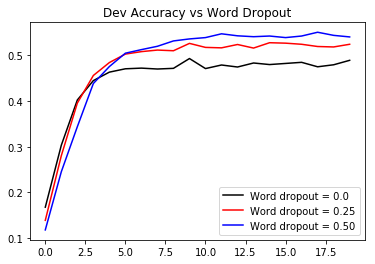

<Figure size 432x288 with 0 Axes>

In [92]:
plt.plot(x, y00, color='black', label='Word dropout = 0.0')
plt.plot(x, y25, color='red', label='Word dropout = 0.25')
plt.plot(x, y50, color='blue', label='Word dropout = 0.50')
plt.title('Dev Accuracy vs Word Dropout')
plt.legend()
plt.savefig('dev-acc-vs-word-dropout')
plt.show()
plt.clf()

# Predict Answers

In [39]:
aug_best_idx = val_tracker['acc'].index(max(val_tracker['acc']))

In [40]:
val_tracker['acc'][aug_best_idx]

0.5859375

In [41]:
tracker['acc'][aug_best_idx]

0.5817569637652358

In [42]:
base_val_tracker = pickle.load(open('bin/gru-non-aug/val-tracker', 'rb'))
base_train_tracker = pickle.load(open('bin/gru-non-aug/train-tracker', 'rb'))

In [43]:
non_aug_best_idx = base_val_tracker['acc'].index(max(base_val_tracker['acc']))

In [44]:
base_val_tracker['acc'][non_aug_best_idx]

0.56982421875

In [45]:
base_train_tracker['acc'][non_aug_best_idx]

0.8926478794642857

# Graph Results

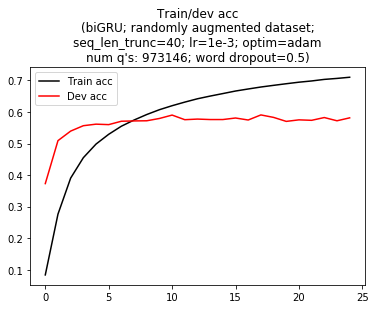

In [134]:
info = 'biGRU; randomly augmented dataset;\nseq_len_trunc=40; lr=1e-3; optim=adam\nnum q\'s: 973146; word dropout=0.5'
train_val_plot(tracker, val_tracker, info, mode='acc')

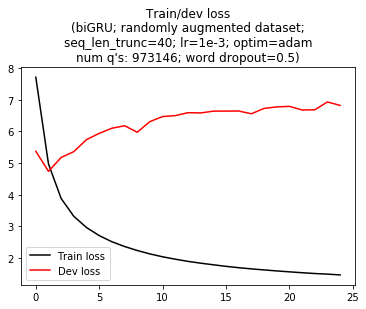

In [135]:
info = 'biGRU; randomly augmented dataset;\nseq_len_trunc=40; lr=1e-3; optim=adam\nnum q\'s: 973146; word dropout=0.5'
train_val_plot(tracker, val_tracker, info, mode='loss')

In [136]:
import pickle

In [137]:
pickle.dump(tracker, open('train_tracker', 'wb'))

In [138]:
pickle.dump(val_tracker, open('val_tracker', 'wb'))

In [139]:
torch.save(model, open('model', 'wb'))

/usr/local/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type QuestionAnswerer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
